In [156]:
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, SpatialDropout1D
import tensorflow as tf
from keras import regularizers

In [157]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [158]:
import pickle

emojis = pd.read_csv('data/Emoji_Sentiment_Data_v1.0.csv')
sentiment = pd.read_csv('data/sentiment.csv')
with open('data/sentiment_texts_demoji.pickle', 'rb') as f:
    texts = pickle.load(f)

x, y = texts.MessageText, texts.SentimentScore

In [159]:
from sklearn.model_selection import train_test_split

max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(x)
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_test).values

In [181]:
from keras.layers import Bidirectional, Conv1D, MaxPooling1D
from keras.optimizers import RMSprop, Adam
import optuna
from optuna.integration import TFKerasPruningCallback

embed_dim = 115
lstm1_out = 35

spat_dropout = 0.25

l1 = 0.075
l2 = 0.07

beta1 = 0.92
beta2 = 0.9


learning_rate = 0.002
batch_size = 512

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(spat_dropout))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(CuDNNLSTM(lstm1_out, kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))))
#model.add(CuDNNLSTM(lstm2_out, kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)))
model.add(Dense(6, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate, beta_1=beta1, beta_2=beta2),
              metrics=['accuracy'])
model.build(X_train.shape[1])
#y_pred = model.predict(X_test).argmax(axis=1)


history = model.fit(X_train, y_train, epochs=40, batch_size=batch_size, verbose=1, validation_data=(X_test, y_val))

Epoch 1/40
18/18 [==============================] - 5s 132ms/step - loss: 60.3460 - accuracy: 0.3948 - val_loss: 46.9585 - val_accuracy: 0.3978
Epoch 2/40
18/18 [==============================] - 2s 94ms/step - loss: 37.8259 - accuracy: 0.4676 - val_loss: 27.7935 - val_accuracy: 0.5226
Epoch 3/40
18/18 [==============================] - 2s 91ms/step - loss: 21.1513 - accuracy: 0.5078 - val_loss: 14.0823 - val_accuracy: 0.5355
Epoch 4/40
18/18 [==============================] - 2s 96ms/step - loss: 9.8394 - accuracy: 0.5367 - val_loss: 5.6108 - val_accuracy: 0.5269
Epoch 5/40
18/18 [==============================] - 2s 95ms/step - loss: 3.7449 - accuracy: 0.5495 - val_loss: 2.4033 - val_accuracy: 0.5183
Epoch 6/40
18/18 [==============================] - 2s 93ms/step - loss: 2.1149 - accuracy: 0.5762 - val_loss: 1.6652 - val_accuracy: 0.5957
Epoch 7/40
18/18 [==============================] - 2s 95ms/step - loss: 1.4956 - accuracy: 0.6094 - val_loss: 1.3822 - val_accuracy: 0.5742
Epoch 

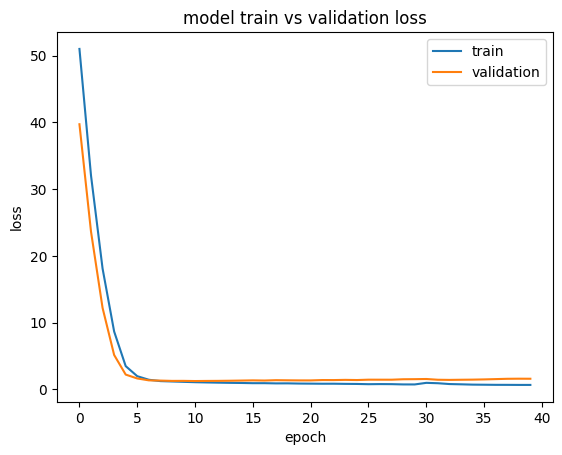

In [177]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [180]:
from sklearn.metrics import accuracy_score, f1_score


def final_score(y_test, y_pred):
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    return (f1 + accuracy) / 2


y_pred = model.predict(X_test).argmax(axis=1)
print(final_score(y_test, y_pred))

15/15 [==============================] - 1s 31ms/step
0.6039096134797622
